In [4]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import hwutils as util

from matplotlib.ticker import MultipleLocator
from functools import partial
from itertools import count

%matplotlib inline

In [5]:
import importlib
importlib.reload(util)

<module 'hwutils' from '/home/elama/Projects/cs1156x/hwutils.py'>

### Linear Regression Error

In [6]:
def get_linreg_expected_ein(sigma, dim, n_samples):
    return sigma**2 * (1 - (dim + 1) / N)

func = partial(get_linreg_expected_ein, sigma=0.1, dim=8)

for N in [10, 25, 100, 500, 1000]:
    print("N = {} => expected Ein = {}".format(N, round(func(n_samples=N), 3)))

N = 10 => expected Ein = 0.001
N = 25 => expected Ein = 0.006
N = 100 => expected Ein = 0.009
N = 500 => expected Ein = 0.01
N = 1000 => expected Ein = 0.01


### Nonlinear Transforms

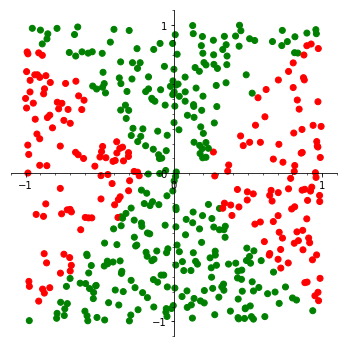

In [8]:
INTERVAL = np.array([-1., 1.])

@np.vectorize
def label_point_by_hyperbolic_surface(x1, x2):
    return (-np.sign(x1**2 - x2**2 - 0.05)).astype(np.int)

@np.vectorize
def colorer(label_value):
    return {-1: 'red', +1: 'green'}[label_value]

X = util.get_2D_points(500, INTERVAL)
y = label_point_by_hyperbolic_surface(*X[:, 1:].T)

# Plotting
plt.figure(figsize=(8,6))
ax = plt.gca()
plt.xlim(*INTERVAL*1.1)
plt.ylim(*INTERVAL*1.1)
majloc, minloc = [MultipleLocator(mul) for mul in (1, .1)]
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(majloc)
    axis.set_minor_locator(minloc)
for pos in ['right', 'top']:   ax.spines[pos].set_color('none')
for pos in ['left', 'bottom']: ax.spines[pos].set_position('zero')
ax.set_aspect('equal')

plt.scatter(*X[:, 1:].T, c=colorer(y))
#plt.scatter(*X[:, 1:].T**2, c=colorer(y))

### Gradient Descent

Problem 4

In [79]:
u, v = sp.symbols('u, v', real=True)
error_function = (u * sp.exp(v) - 2 * v * sp.exp(-u)) ** 2

print("Partial by u: {}".format(sp.diff(error_function, u)))
print("Partial by v: {}".format(sp.diff(error_function, v)))

Partial by u: (u*exp(v) - 2*v*exp(-u))*(4*v*exp(-u) + 2*exp(v))
Partial by v: (u*exp(v) - 2*v*exp(-u))*(2*u*exp(v) - 4*exp(-u))


Problem 5, 6, 7

In [104]:
def evaluate_error_function(u, v):
    return (u*np.exp(v) - 2*v*np.exp(-u)) ** 2

def evaluate_gradient(u, v):
    common = 2 * (u*np.exp(v) - 2*v*np.exp(-u))
    partial_u = common * (np.exp(v) + 2*v*np.exp(-u))
    partial_v = common * (u*np.exp(v) - 2*np.exp(-u))
    return partial_u, partial_v

def update_params_values(u0, v0, learning_rate=0.1):
    partial_u, partial_v = evaluate_gradient(u0, v0)
    return u0 - learning_rate * partial_u, \
           v0 - learning_rate * partial_v

In [106]:
u, v = [1, 1]
error_threshold = 1e-14

for it in count(start=1):
    u, v = update_params_values(u, v)
    if evaluate_error_function(u, v) < error_threshold:
        print("Error fallen under the threshold of {} after {} iterations" \
              .format(error_threshold, it))
        print("Weight vector is {}".format([u, v]))
        break

Error fallen under the threshold of 1e-14 after 10 iterations
Weight vector is [0.044736290397782069, 0.023958714099141746]


In [113]:
u, v = [1, 1]
learning_rate = 0.1

n_iters = 15
for it in range(n_iters):
    u -= learning_rate * evaluate_gradient(u, v)[0]
    v -= learning_rate * evaluate_gradient(u, v)[1]    
    if it == n_iters - 1:
        print("After {} full iterations error value is {}" \
            .format(n_iters, evaluate_error_function(u, v)))

After 15 full iterations error value is 0.13981379199615315


###  Logistic Regression

Problems 8, 9

In [9]:
def fit_logistic_regression(X, y, learning_rate=0.01, threshold=0.01,
                            verbose=False):
    from collections import namedtuple
    
    LogisticRegression = namedtuple(typename='LogisticRegression',
                                    field_names='weights epochs')
    
    @np.vectorize
    def cross_entropy_error_gradient(x, y, w):
        return - y*x / (1 + np.exp(y*x*w))
    
    n_points = X.shape[0]
    w = np.zeros(X.shape[1])
    
    for epoch in count(start=1):
        w_prev = w
        for i in np.random.permutation(n_points):
            w = w - learning_rate * cross_entropy_error_gradient(X[i], y[i], w)
        if np.linalg.norm(w_prev - w) < threshold:
            break
    
    if verbose: print("Converged after {} epochs".format(epoch))
    return LogisticRegression(w, epoch)

In [12]:
INTERVAL = np.array([-1., 1.])

def cross_entropy_error(X, y, w):
    pointwise_error = []
    for i in range(X.shape[0]):
        e_i = np.log(1 + np.exp(-y[i] * w @ X[i]))
        pointwise_error.append(e_i)
    return np.mean(pointwise_error)

def generate_and_evaluate_logreg(train_size=100, test_size=int(1e3)):
    w_true = util.get_2D_line(*np.random.uniform(*INTERVAL, 4))
    X_train, y_train, X_test, y_test = \
        util.get_2D_linearly_separated_datasets(interval=INTERVAL,
                                                weights=w_true,
                                                train_size=train_size,
                                                test_size=test_size)    
    logreg = fit_logistic_regression(X_train, y_train)
    w_hat = logreg.weights
    Eout = cross_entropy_error(X_test, y_test, w_hat)
    
    return Eout, logreg.epochs

def run_experiment(n_runs=100):
    Eout, epochs = [], []
    for _ in range(n_runs):
        err, ep = generate_and_evaluate_logreg()
        Eout.append(err)
        epochs.append(ep)
    print("Avg out-of-sample error: {}\nAvg epochs to converge: {}".
          format(np.mean(Eout), np.mean(epochs)))

In [13]:
run_experiment()

Avg out-of-sample error: 0.2459373345843895
Avg epochs to converge: 83.08


### PLA as SGD

Problem 10

If we define a pointwise error measure for linear classification as $e_n(w)=max(0, -y_n\mathbf{w}^T\mathbf{x}_n)$, then PLA can be viewed as SGD with $\eta=1$:

- $y_n\mathbf{w}^T\mathbf{x}_n$ defines *agreement* between $y$ and $h(\mathbf{x})$ on a specific point: it will be positive if $y_n=sign(\mathbf{w}^T\mathbf{x}_n)$ and negative otherwise
- because second argument is taken with inverse sign $e_n$ will output $0$ on the points where there's an agreement -- thus $\nabla e_n=\overrightarrow{0}$
- on the points where $y$ and $h(\mathbf{x})$ do not agree $e_n$ will behave linearly and $\nabla e_n=y_n\mathbf{x}_n$, which, considering $\eta=1$, is exactly how PLA is realized